In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime as dt
from dateutil.parser import *
import random
import time
import json
from numpy import argmax
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score,classification_report, roc_auc_score,accuracy_score, \
precision_score, f1_score, recall_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import re
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)

from sklearn.linear_model import Ridge,Lasso,ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LinearRegression

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

%config InlineBackend.figure_format = 'retina'
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [543]:
df_regression = pd.read_csv('../data/merged_train_final.csv')

In [544]:
test_df_regression = pd.read_csv('../data/merged_test_final.csv')

In [545]:
merged_train_multi = pd.read_csv('../data/merged_train_multi.csv')

In [546]:
merged_test_multi = pd.read_csv('../data/merged_test_multi.csv')

In [602]:
#non-smote

x = df_regression.drop(['wnvpresent'],axis=1)
y = df_regression['wnvpresent']

#x = merged_train_multi.drop(['wnvpresent'],axis=1)
#y = merged_train_multi['wnvpresent']

display(y.value_counts(normalize=True))

x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [548]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svm': SVC(random_state=42, probability=True),
          'xg': XGBClassifier(random_state=42)
}

In [646]:
# Function to run model -- input model
def get_model_scores(model_name,
                     mod, 
                     mod_params={}, 
                     grid_search=False):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional), grid_seach(boolean, optional)
    If grid_search is True, then please also input the relevant 
    params for GridSearching
    """
    
    # empty dict for appending results
    results = {}
    
    # instantiate pipe
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    # check if GridSearch true or false
    if grid_search:
        
        # combine vectorizer and mod params together
        gs_params = {}
        gs_params.update(mod_params)
        
        # instantiate GridSearchCV
        gs = GridSearchCV(pipe, 
                          param_grid=gs_params,
                          cv=5, 
                          verbose=2, 
                          n_jobs=-1,
                         scoring = 'recall'
                         )
        
        # fit model
        gs.fit(x_train_sc, y_train)
        pipe = gs
        
    else:
        # else fit model
        pipe.fit(x_train_sc, y_train)
    
    # create predictions and confusion matrix
    predictions = pipe.predict(x_test_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(x_test_sc)[:,1]
    y_train_pred_prob = pipe.predict_proba(x_train_sc)[:,1]

    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_score'] = pipe.score(x_train_sc, y_train)
    results['test_score'] = pipe.score(x_test_sc, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['specificity'] = tn/(tn + fp)
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    
    results['is_tuned'] = grid_search
    
    if grid_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
    
    # add results to list for model evaluation later
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [550]:
# create list to store results
model_eval =[]

In [483]:
lr_reg = get_model_scores('lr_non_smote', 'lr')

METRICS-->


{'model_name': 'lr_non_smote',
 'model': 'lr',
 'train_score': 0.9477232081441739,
 'test_score': 0.948019801980198,
 'recall': 0.0,
 'specificity': 0.9991304347826087,
 'precision': 0.0,
 'train_auc': 0.8329533835507847,
 'test_auc': 0.7468951612903225,
 'is_tuned': False}

True Negatives: 2298
False Positives: 2
False Negatives: 124
True Positives: 0


In [613]:
#smote with vif
x = df_regression.drop(['wnvpresent'],axis=1)
y = df_regression['wnvpresent']

#x = merged_train_multi.drop(['wnvpresent'],axis=1)
#y = merged_train_multi['wnvpresent']

display(y.value_counts(normalize=True))

x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

#storing unsmote versions of y for modelling later
y_train_unsmote = y_train.copy()

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [485]:
lr_reg = get_model_scores('lr_vif', 'lr')

METRICS-->


{'model_name': 'lr_vif',
 'model': 'lr',
 'train_score': 0.8057329462989841,
 'test_score': 0.7541254125412541,
 'recall': 0.5887096774193549,
 'specificity': 0.7630434782608696,
 'precision': 0.11812297734627832,
 'train_auc': 0.8751527212826059,
 'test_auc': 0.7461448106591865,
 'is_tuned': False}

True Negatives: 1755
False Positives: 545
False Negatives: 51
True Positives: 73


In [486]:
svm_reg = get_model_scores('svm_vif', 'svm')

METRICS-->


{'model_name': 'svm_vif',
 'model': 'svm',
 'train_score': 0.9130624092888244,
 'test_score': 0.8407590759075908,
 'recall': 0.4274193548387097,
 'specificity': 0.8630434782608696,
 'precision': 0.14402173913043478,
 'train_auc': 0.9712810577160058,
 'test_auc': 0.7514708976157083,
 'is_tuned': False}

True Negatives: 1985
False Positives: 315
False Negatives: 71
True Positives: 53


In [487]:
xg_reg = get_model_scores('xg_vif', 'xg')

[17:40:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_vif',
 'model': 'xg',
 'train_score': 0.9776487663280116,
 'test_score': 0.9426567656765676,
 'recall': 0.08064516129032258,
 'specificity': 0.9891304347826086,
 'precision': 0.2857142857142857,
 'train_auc': 0.9971802490304831,
 'test_auc': 0.8572072230014025,
 'is_tuned': False}

True Negatives: 2275
False Positives: 25
False Negatives: 114
True Positives: 10


In [488]:
et_reg = get_model_scores('et_vif', 'et')

METRICS-->


{'model_name': 'et_vif',
 'model': 'et',
 'train_score': 0.9918722786647315,
 'test_score': 0.941006600660066,
 'recall': 0.07258064516129033,
 'specificity': 0.9878260869565217,
 'precision': 0.24324324324324326,
 'train_auc': 0.9998393056131918,
 'test_auc': 0.6866374474053296,
 'is_tuned': False}

True Negatives: 2272
False Positives: 28
False Negatives: 115
True Positives: 9


In [489]:
model_eval

[{'model_name': 'lr_non_smote',
  'model': 'lr',
  'train_score': 0.9477232081441739,
  'test_score': 0.948019801980198,
  'recall': 0.0,
  'specificity': 0.9991304347826087,
  'precision': 0.0,
  'train_auc': 0.8329533835507847,
  'test_auc': 0.7468951612903225,
  'is_tuned': False},
 {'model_name': 'lr_vif',
  'model': 'lr',
  'train_score': 0.8057329462989841,
  'test_score': 0.7541254125412541,
  'recall': 0.5887096774193549,
  'specificity': 0.7630434782608696,
  'precision': 0.11812297734627832,
  'train_auc': 0.8751527212826059,
  'test_auc': 0.7461448106591865,
  'is_tuned': False},
 {'model_name': 'svm_vif',
  'model': 'svm',
  'train_score': 0.9130624092888244,
  'test_score': 0.8407590759075908,
  'recall': 0.4274193548387097,
  'specificity': 0.8630434782608696,
  'precision': 0.14402173913043478,
  'train_auc': 0.9712810577160058,
  'test_auc': 0.7514708976157083,
  'is_tuned': False},
 {'model_name': 'xg_vif',
  'model': 'xg',
  'train_score': 0.9776487663280116,
  'test_

In [636]:
#changing to test on dataset without vif

#x = df_regression.drop(['wnvpresent'],axis=1)
#y = df_regression['wnvpresent']

x = merged_train_multi.drop(['wnvpresent'],axis=1)
y = merged_train_multi['wnvpresent']

display(y.value_counts(normalize=True))

x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

#storing unsmote versions of y for modelling later
y_train_unsmote = y_train.copy()

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [491]:
lr_base = get_model_scores('lr_no_vif', 'lr')

METRICS-->


{'model_name': 'lr_no_vif',
 'model': 'lr',
 'train_score': 0.8259796806966618,
 'test_score': 0.775990099009901,
 'recall': 0.6048387096774194,
 'specificity': 0.7852173913043479,
 'precision': 0.13181019332161686,
 'train_auc': 0.8874044228083443,
 'test_auc': 0.7729926367461429,
 'is_tuned': False}

True Negatives: 1806
False Positives: 494
False Negatives: 49
True Positives: 75


In [492]:
svm_base = get_model_scores('svm_no_vif', 'svm')

METRICS-->


{'model_name': 'svm_no_vif',
 'model': 'svm',
 'train_score': 0.9298984034833091,
 'test_score': 0.8535478547854786,
 'recall': 0.45161290322580644,
 'specificity': 0.8752173913043478,
 'precision': 0.16326530612244897,
 'train_auc': 0.9783968162352202,
 'test_auc': 0.777312412342216,
 'is_tuned': False}

True Negatives: 2013
False Positives: 287
False Negatives: 68
True Positives: 56


In [493]:
xg_base = get_model_scores('xg_no_vif', 'xg')

[17:42:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_no_vif',
 'model': 'xg',
 'train_score': 0.978011611030479,
 'test_score': 0.9422442244224423,
 'recall': 0.0967741935483871,
 'specificity': 0.9878260869565217,
 'precision': 0.3,
 'train_auc': 0.9974362836276467,
 'test_auc': 0.8528962131837308,
 'is_tuned': False}

True Negatives: 2272
False Positives: 28
False Negatives: 112
True Positives: 12


In [494]:
model_eval

[{'model_name': 'lr_non_smote',
  'model': 'lr',
  'train_score': 0.9477232081441739,
  'test_score': 0.948019801980198,
  'recall': 0.0,
  'specificity': 0.9991304347826087,
  'precision': 0.0,
  'train_auc': 0.8329533835507847,
  'test_auc': 0.7468951612903225,
  'is_tuned': False},
 {'model_name': 'lr_vif',
  'model': 'lr',
  'train_score': 0.8057329462989841,
  'test_score': 0.7541254125412541,
  'recall': 0.5887096774193549,
  'specificity': 0.7630434782608696,
  'precision': 0.11812297734627832,
  'train_auc': 0.8751527212826059,
  'test_auc': 0.7461448106591865,
  'is_tuned': False},
 {'model_name': 'svm_vif',
  'model': 'svm',
  'train_score': 0.9130624092888244,
  'test_score': 0.8407590759075908,
  'recall': 0.4274193548387097,
  'specificity': 0.8630434782608696,
  'precision': 0.14402173913043478,
  'train_auc': 0.9712810577160058,
  'test_auc': 0.7514708976157083,
  'is_tuned': False},
 {'model_name': 'xg_vif',
  'model': 'xg',
  'train_score': 0.9776487663280116,
  'test_

In [495]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

    'lr__C':[1, 10, 20],

}

svc_params = {
    'svm__C':[1, 10],
    'svm__gamma':['scale', 'auto'], 
    'svm__kernel':['rbf', 'sigmoid'],
}

xg_params = {
    'xg__booster': ['gbtree', 'gblinear'],
    'xg__scale_pos_weight': [0.5,1],
    'xg__gamma': [0,1],
    'xg__reg_alpha': [0, 1],
    'xg__reg_lambda': [1, 5]}

In [114]:
lr_tune = get_model_scores_roc('lr_tune', 'lr',lr_params,True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
  

BEST PARAMS-->


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 20, 'lr__penalty': 'l1'}

METRICS-->


{'model_name': 'lr_tune',
 'model': 'lr',
 'train_score': 0.8894924071191288,
 'test_score': 0.7765971248246846,
 'recall': 0.5887096774193549,
 'specificity': 0.7882608695652173,
 'precision': 0.13035714285714287,
 'train_auc': 0.8894924071191288,
 'test_auc': 0.7765971248246846,
 'is_tuned': True}

True Negatives: 1813
False Positives: 487
False Negatives: 51
True Positives: 73


In [115]:
lr_tune_recall = get_model_scores_recall('lr_tune_recall', 'lr',lr_params,True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
  

BEST PARAMS-->


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 10, 'lr__penalty': 'l2'}

METRICS-->


{'model_name': 'lr_tune_recall',
 'model': 'lr',
 'train_score': 0.8795355587808418,
 'test_score': 0.5887096774193549,
 'recall': 0.5887096774193549,
 'specificity': 0.7882608695652173,
 'precision': 0.13035714285714287,
 'train_auc': 0.8893119010955909,
 'test_auc': 0.7761553295932678,
 'is_tuned': True}

True Negatives: 1813
False Positives: 487
False Negatives: 51
True Positives: 73


In [116]:
svm_tune = get_model_scores_roc('svm_tune', 'svm',svc_params,True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


BEST PARAMS-->


{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

METRICS-->


{'model_name': 'svm_tune',
 'model': 'svm',
 'train_score': 0.9935818196372185,
 'test_score': 0.7764638849929875,
 'recall': 0.3548387096774194,
 'specificity': 0.9265217391304348,
 'precision': 0.20657276995305165,
 'train_auc': 0.9935817353772005,
 'test_auc': 0.7742917251051893,
 'is_tuned': True}

True Negatives: 2131
False Positives: 169
False Negatives: 80
True Positives: 44


In [117]:
svm_tune_recall = get_model_scores_recall('svm_tune_recall', 'svm',svc_params,True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
BEST PARAMS-->


{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

METRICS-->


{'model_name': 'svm_tune_recall',
 'model': 'svm',
 'train_score': 0.997532656023222,
 'test_score': 0.3548387096774194,
 'recall': 0.3548387096774194,
 'specificity': 0.9265217391304348,
 'precision': 0.20657276995305165,
 'train_auc': 0.9935817353772005,
 'test_auc': 0.7742917251051893,
 'is_tuned': True}

True Negatives: 2131
False Positives: 169
False Negatives: 80
True Positives: 44


In [118]:
xgb_tune = get_model_scores_roc('xg_tune', 'xg',xg_params,True)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS-->


{'xg__booster': 'gbtree',
 'xg__gamma': 1,
 'xg__reg_alpha': 0,
 'xg__reg_lambda': 1,
 'xg__scale_pos_weight': 0.5}

METRICS-->


{'model_name': 'xg_tune',
 'model': 'xg',
 'train_score': 0.995142209845362,
 'test_score': 0.8477857643758766,
 'recall': 0.056451612903225805,
 'specificity': 0.9947826086956522,
 'precision': 0.3684210526315789,
 'train_auc': 0.995142209845362,
 'test_auc': 0.8477857643758766,
 'is_tuned': True}

True Negatives: 2288
False Positives: 12
False Negatives: 117
True Positives: 7


In [121]:
xgb_tune_recall = get_model_scores_recall('xg_tune_recall', 'xg',xg_params,True)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS-->


{'xg__booster': 'gbtree',
 'xg__gamma': 0,
 'xg__reg_alpha': 0,
 'xg__reg_lambda': 1,
 'xg__scale_pos_weight': 1}

METRICS-->


{'model_name': 'xg_tune_recall',
 'model': 'xg',
 'train_score': 0.9631349782293178,
 'test_score': 0.0967741935483871,
 'recall': 0.0967741935483871,
 'specificity': 0.9878260869565217,
 'precision': 0.3,
 'train_auc': 0.9974362836276467,
 'test_auc': 0.8528962131837308,
 'is_tuned': True}

True Negatives: 2272
False Positives: 28
False Negatives: 112
True Positives: 12


In [496]:
pd.DataFrame(model_eval).sort_values('recall',ascending=False)

model_name model  train_score  test_score    recall  specificity  \
5     lr_no_vif    lr     0.825980    0.775990  0.604839     0.785217   
1        lr_vif    lr     0.805733    0.754125  0.588710     0.763043   
6    svm_no_vif   svm     0.929898    0.853548  0.451613     0.875217   
2       svm_vif   svm     0.913062    0.840759  0.427419     0.863043   
7     xg_no_vif    xg     0.978012    0.942244  0.096774     0.987826   
3        xg_vif    xg     0.977649    0.942657  0.080645     0.989130   
4        et_vif    et     0.991872    0.941007  0.072581     0.987826   
0  lr_non_smote    lr     0.947723    0.948020  0.000000     0.999130   

   precision  train_auc  test_auc  is_tuned  
5   0.131810   0.887404  0.772993     False  
1   0.118123   0.875153  0.746145     False  
6   0.163265   0.978397  0.777312     False  
2   0.144022   0.971281  0.751471     False  
7   0.300000   0.997436  0.852896     False  
3   0.285714   0.997180  0.857207     False  
4   0.243243   0.999839  0.686637     False  
0   0.000000   0.832953  0.746895     False

In [497]:
pd.DataFrame(model_eval).sort_values('test_auc',ascending=False)

model_name model  train_score  test_score    recall  specificity  \
3        xg_vif    xg     0.977649    0.942657  0.080645     0.989130   
7     xg_no_vif    xg     0.978012    0.942244  0.096774     0.987826   
6    svm_no_vif   svm     0.929898    0.853548  0.451613     0.875217   
5     lr_no_vif    lr     0.825980    0.775990  0.604839     0.785217   
2       svm_vif   svm     0.913062    0.840759  0.427419     0.863043   
0  lr_non_smote    lr     0.947723    0.948020  0.000000     0.999130   
1        lr_vif    lr     0.805733    0.754125  0.588710     0.763043   
4        et_vif    et     0.991872    0.941007  0.072581     0.987826   

   precision  train_auc  test_auc  is_tuned  
3   0.285714   0.997180  0.857207     False  
7   0.300000   0.997436  0.852896     False  
6   0.163265   0.978397  0.777312     False  
5   0.131810   0.887404  0.772993     False  
2   0.144022   0.971281  0.751471     False  
0   0.000000   0.832953  0.746895     False  
1   0.118123   0.875153  0.746145     False  
4   0.243243   0.999839  0.686637     False

In [498]:
#pd.DataFrame(model_eval).sort_values('test_auc',ascending=False).to_csv('modelling_recall_table.csv',index=False)

In [500]:
pd.read_csv('modelling_recall_table.csv')

model_name model  train_score  test_score    recall  specificity  \
0        xg_vif    xg     0.977649    0.942657  0.080645     0.989130   
1     xg_no_vif    xg     0.978012    0.942244  0.096774     0.987826   
2    svm_no_vif   svm     0.929898    0.853548  0.451613     0.875217   
3     lr_no_vif    lr     0.825980    0.775990  0.604839     0.785217   
4       svm_vif   svm     0.913062    0.840759  0.427419     0.863043   
5  lr_non_smote    lr     0.947723    0.948020  0.000000     0.999130   
6        lr_vif    lr     0.805733    0.754125  0.588710     0.763043   
7        et_vif    et     0.991872    0.941007  0.072581     0.987826   

   precision  train_auc  test_auc  is_tuned  
0   0.285714   0.997180  0.857207     False  
1   0.300000   0.997436  0.852896     False  
2   0.163265   0.978397  0.777312     False  
3   0.131810   0.887404  0.772993     False  
4   0.144022   0.971281  0.751471     False  
5   0.000000   0.832953  0.746895     False  
6   0.118123   0.875153  0.746145     False  
7   0.243243   0.999839  0.686637     False

In [501]:
#updating lr params
models['lr'] = LogisticRegression(random_state = 42, penalty = 'l2', C = 20, max_iter=5_000, solver='saga')

In [502]:
lr_1 = get_model_scores('lr_1','lr')

METRICS-->


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'model_name': 'lr_1',
 'model': 'lr',
 'train_score': 0.8276487663280117,
 'test_score': 0.778052805280528,
 'recall': 0.5887096774193549,
 'specificity': 0.7882608695652173,
 'precision': 0.13035714285714287,
 'train_auc': 0.8894260312899576,
 'test_auc': 0.7764533660589059,
 'is_tuned': False}

True Negatives: 1813
False Positives: 487
False Negatives: 51
True Positives: 73


In [503]:
lr_1_coef = pd.DataFrame(lr_1.named_steps['lr'].coef_.T,x.columns,columns = ['coefficients']).sort_values(by='coefficients', ascending=False)
lr_1_coef

coefficients
week*dewpoint                   6.190326
tavg_minus_2w                   5.462115
week*tavg                       3.904598
dewpoint*dewpoint_minus_2w      2.421766
trap_T900                       1.348323
...                                  ...
tavg                           -1.228683
week                           -2.071968
tavg*dewpoint_minus_2w         -4.494567
dewpoint                       -5.064231
week*tavg_minus_2w             -7.681426

[168 rows x 1 columns]

In [504]:
def plot_precision_recall(model,model_label):
    probs = model.predict_proba(x_test_sc)
    # Keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # Predict class values
    yhat = model.predict(x_test_sc)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # Calculate F1 score
    f1 = f1_score(y_test, yhat)
    # Calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # Calculate average precision score
    ap = average_precision_score(y_test, probs)
    print(f'log_reg: f1=%.3f pr-auc=%.3f avg. prec=%.3f' % (f1, auc_score, ap))
    # Plot the ROC curve for the model
    plt.plot(recall, precision, marker='.', label=model_label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    

log_reg: f1=0.213 pr-auc=0.147 avg. prec=0.150


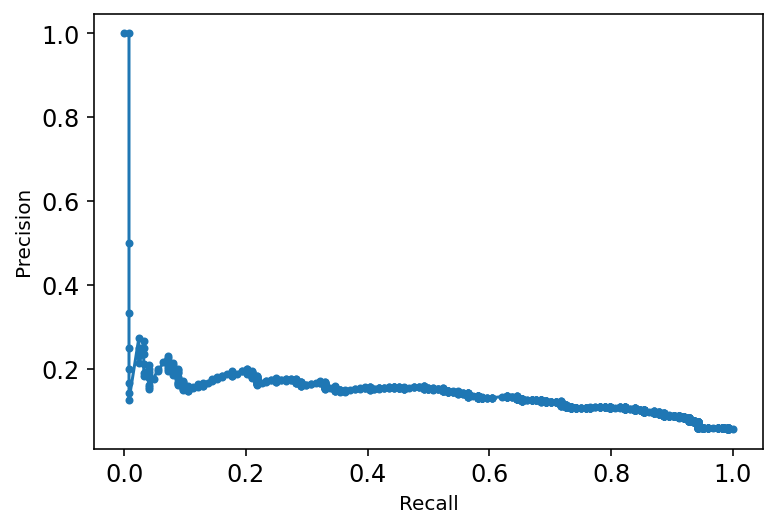

In [505]:
plot_precision_recall(lr_1,'lr')


In [637]:
weather_train_df = pd.read_csv('../data/weather_train_merged.csv')

In [638]:
# trying month
x_train_month = pd.DataFrame(weather_train_df['month'].loc[x_train.index])

x_train_month = pd.get_dummies(
    x_train_month,
    columns = ['month'],
    drop_first=True
)

x_test_month = pd.DataFrame(weather_train_df['month'].loc[x_test.index])

x_test_month = pd.get_dummies(
    x_test_month,
    columns = ['month'],
    drop_first=True
)

In [639]:
#creating new df to include month
lin_x_train = pd.concat([x_train,x_train_month],axis=1)

lin_x_test = pd.concat([x_test,x_test_month],axis=1)

In [641]:
#running linear regression
lin_x_train = lin_x_train.drop('week',axis=1)
lin_y_train = weather_train_df['nummosquitos'].loc[x_train.index].values

lin_x_test = lin_x_test.drop(['week'],axis=1).loc[x_test.index]
lin_y_test = weather_train_df['nummosquitos'].loc[x_test.index].values

ss = StandardScaler()
x_train_sc = ss.fit_transform(lin_x_train)
x_test_sc = ss.transform(lin_x_test)

lin_r = LinearRegression()

lin_r.fit(x_train_sc,lin_y_train)

lin_r_model_preds_train = lin_r.predict(x_train_sc)
lin_r_model_preds_test = lin_r.predict(x_test_sc)

# here we need to fit scale the num mosquitos predictions before putting into logistic regression model

num_train_sc = ss.fit_transform(pd.DataFrame(lin_r_model_preds_train.reshape(-1,1)))
num_test_sc = ss.fit_transform(pd.DataFrame(lin_r_model_preds_test.reshape(-1,1)))

In [642]:
#creating new df to put linear reg results into logreg 
x_train_sc_1 = pd.concat([pd.DataFrame(x_train_sc,columns= lin_x_train.columns), pd.DataFrame(num_train_sc)],axis=1)
x_train_sc_1 = x_train_sc_1.rename(columns={0: 'nummosquitos'})

x_test_sc = pd.concat([pd.DataFrame(x_test_sc,columns= lin_x_test.columns), pd.DataFrame(num_test_sc)],axis=1)
x_test_sc = x_test_sc.rename(columns={0: 'nummosquitos'})

In [643]:
sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc_1,y_train_unsmote)

In [647]:
lr_lin = get_model_scores('lr_lin','lr')

METRICS-->


{'model_name': 'lr_lin',
 'model': 'lr',
 'train_score': 0.83388969521045,
 'test_score': 0.7883663366336634,
 'recall': 0.6693548387096774,
 'specificity': 0.7947826086956522,
 'precision': 0.14954954954954955,
 'train_auc': 0.9004495587934808,
 'test_auc': 0.8024772089761572,
 'is_tuned': False}

True Negatives: 1828
False Positives: 472
False Negatives: 41
True Positives: 83


In [648]:
xg_lin = get_model_scores('xg_lin','xg')

[18:31:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/user_1/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_lin',
 'model': 'xg',
 'train_score': 0.9814223512336719,
 'test_score': 0.943069306930693,
 'recall': 0.13709677419354838,
 'specificity': 0.9865217391304347,
 'precision': 0.3541666666666667,
 'train_auc': 0.9988596986440457,
 'test_auc': 0.8523089060308556,
 'is_tuned': False}

True Negatives: 2269
False Positives: 31
False Negatives: 107
True Positives: 17


In [651]:
lr_lin_coef = pd.DataFrame(lr_lin.named_steps['lr'].coef_.T,x_train_sc_1.columns,
                           columns = ['coefficients']).sort_values(by='coefficients', ascending=False)



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'nummosquitos'),
  Text(1, 0, 'week*dewpoint_minus_2w'),
  Text(2, 0, 'week*dewpoint'),
  Text(3, 0, 'tavg'),
  Text(4, 0, 'tavg_minus_2w'),
  Text(5, 0, 'month_8'),
  Text(6, 0, 'dewpoint*dewpoint_minus_2w'),
  Text(7, 0, 'month_9'),
  Text(8, 0, 'species_CULEX PIPIENS'),
  Text(9, 0, 'trap_T900')])

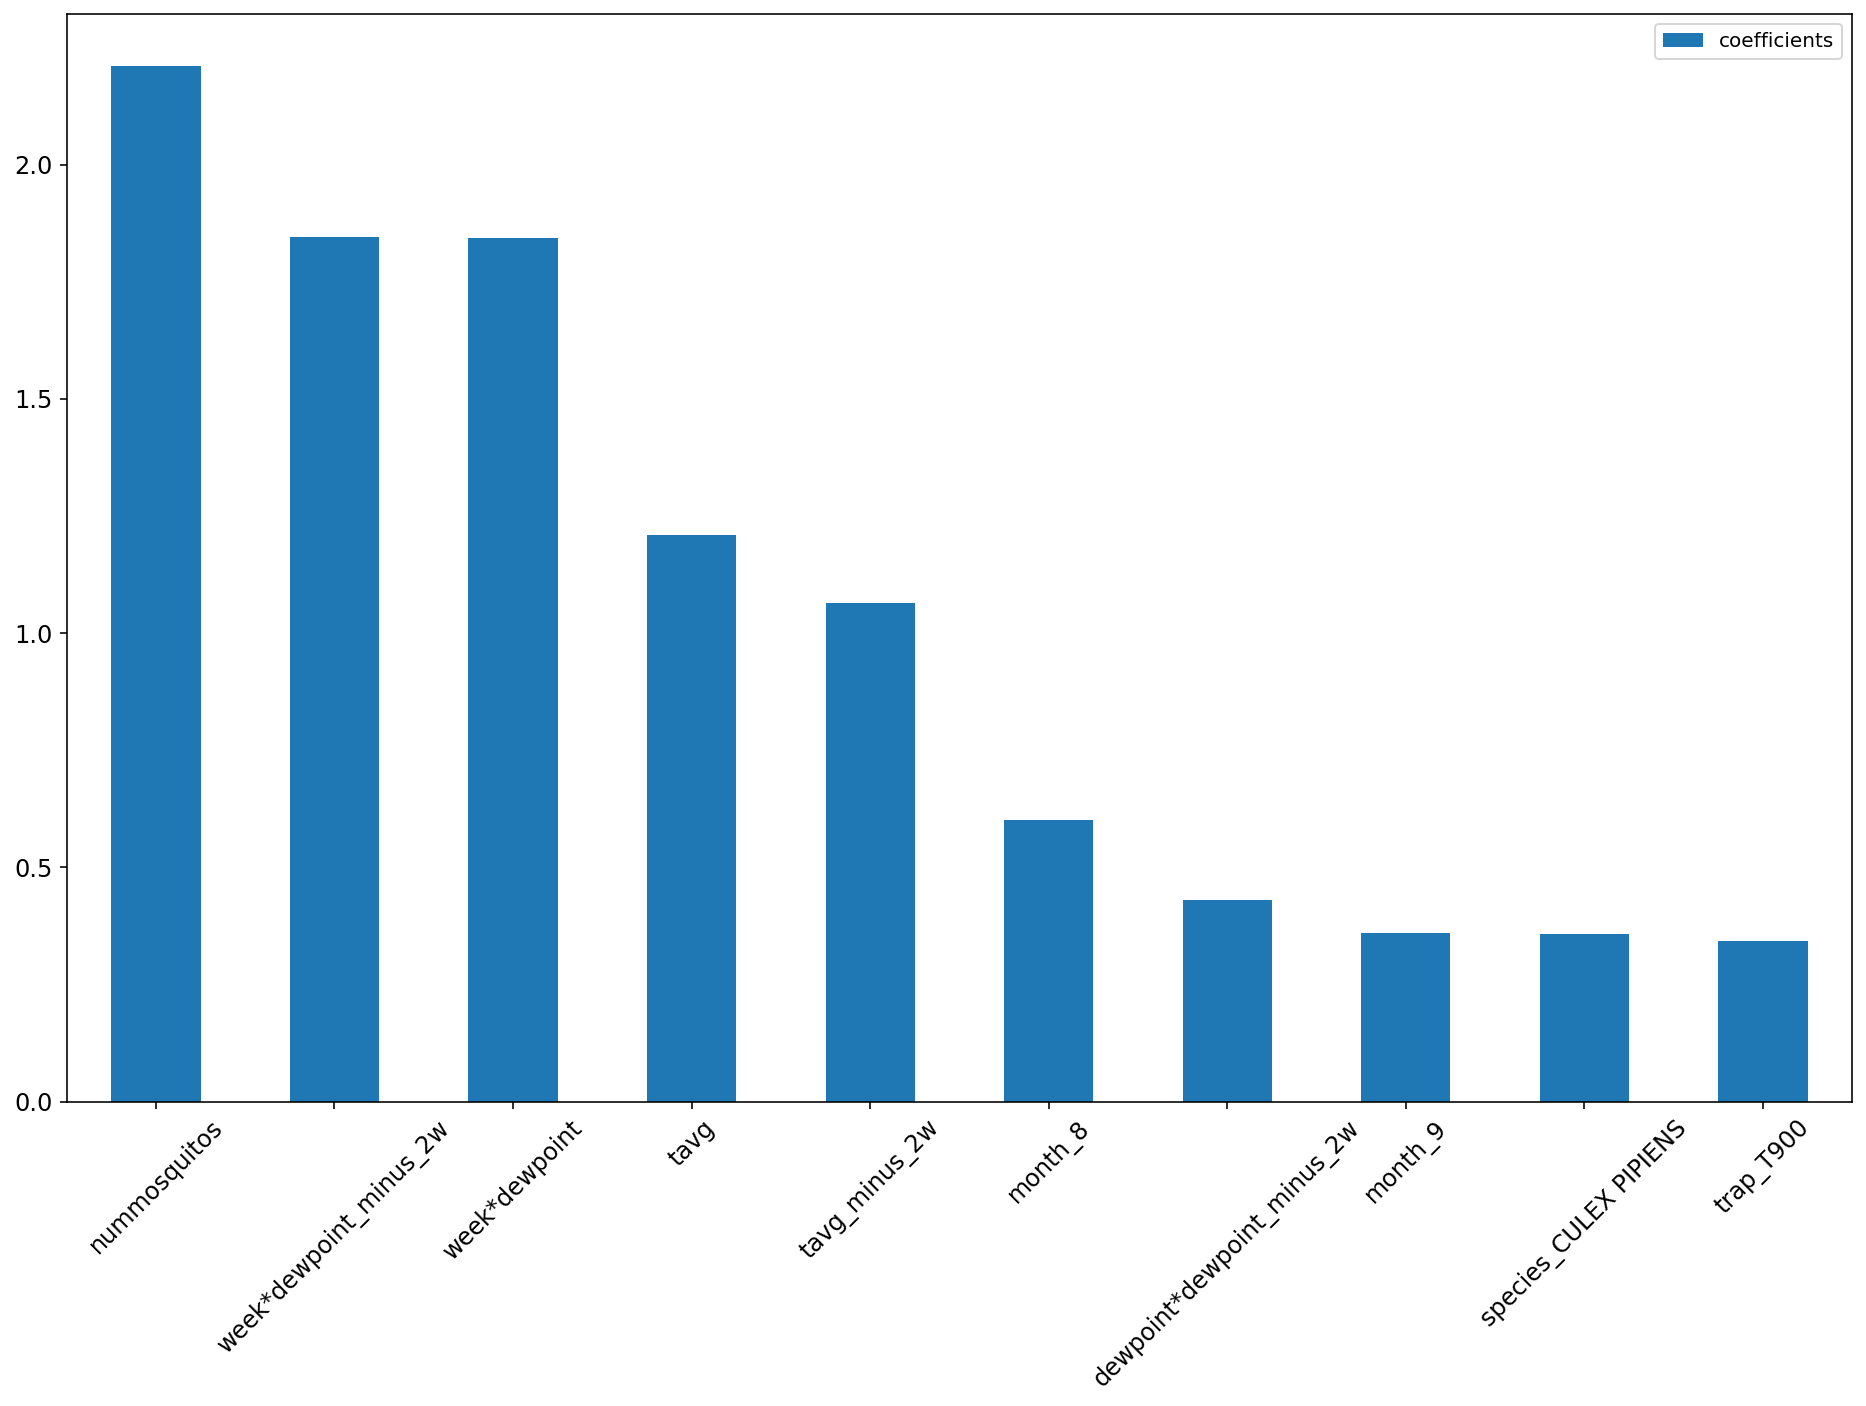

In [652]:
lr_lin_coef.head(10).plot(kind='bar',figsize = (16,10))
plt.xticks(rotation = 45)

In [653]:
spray = pd.read_csv('../data/spray_clean.csv')

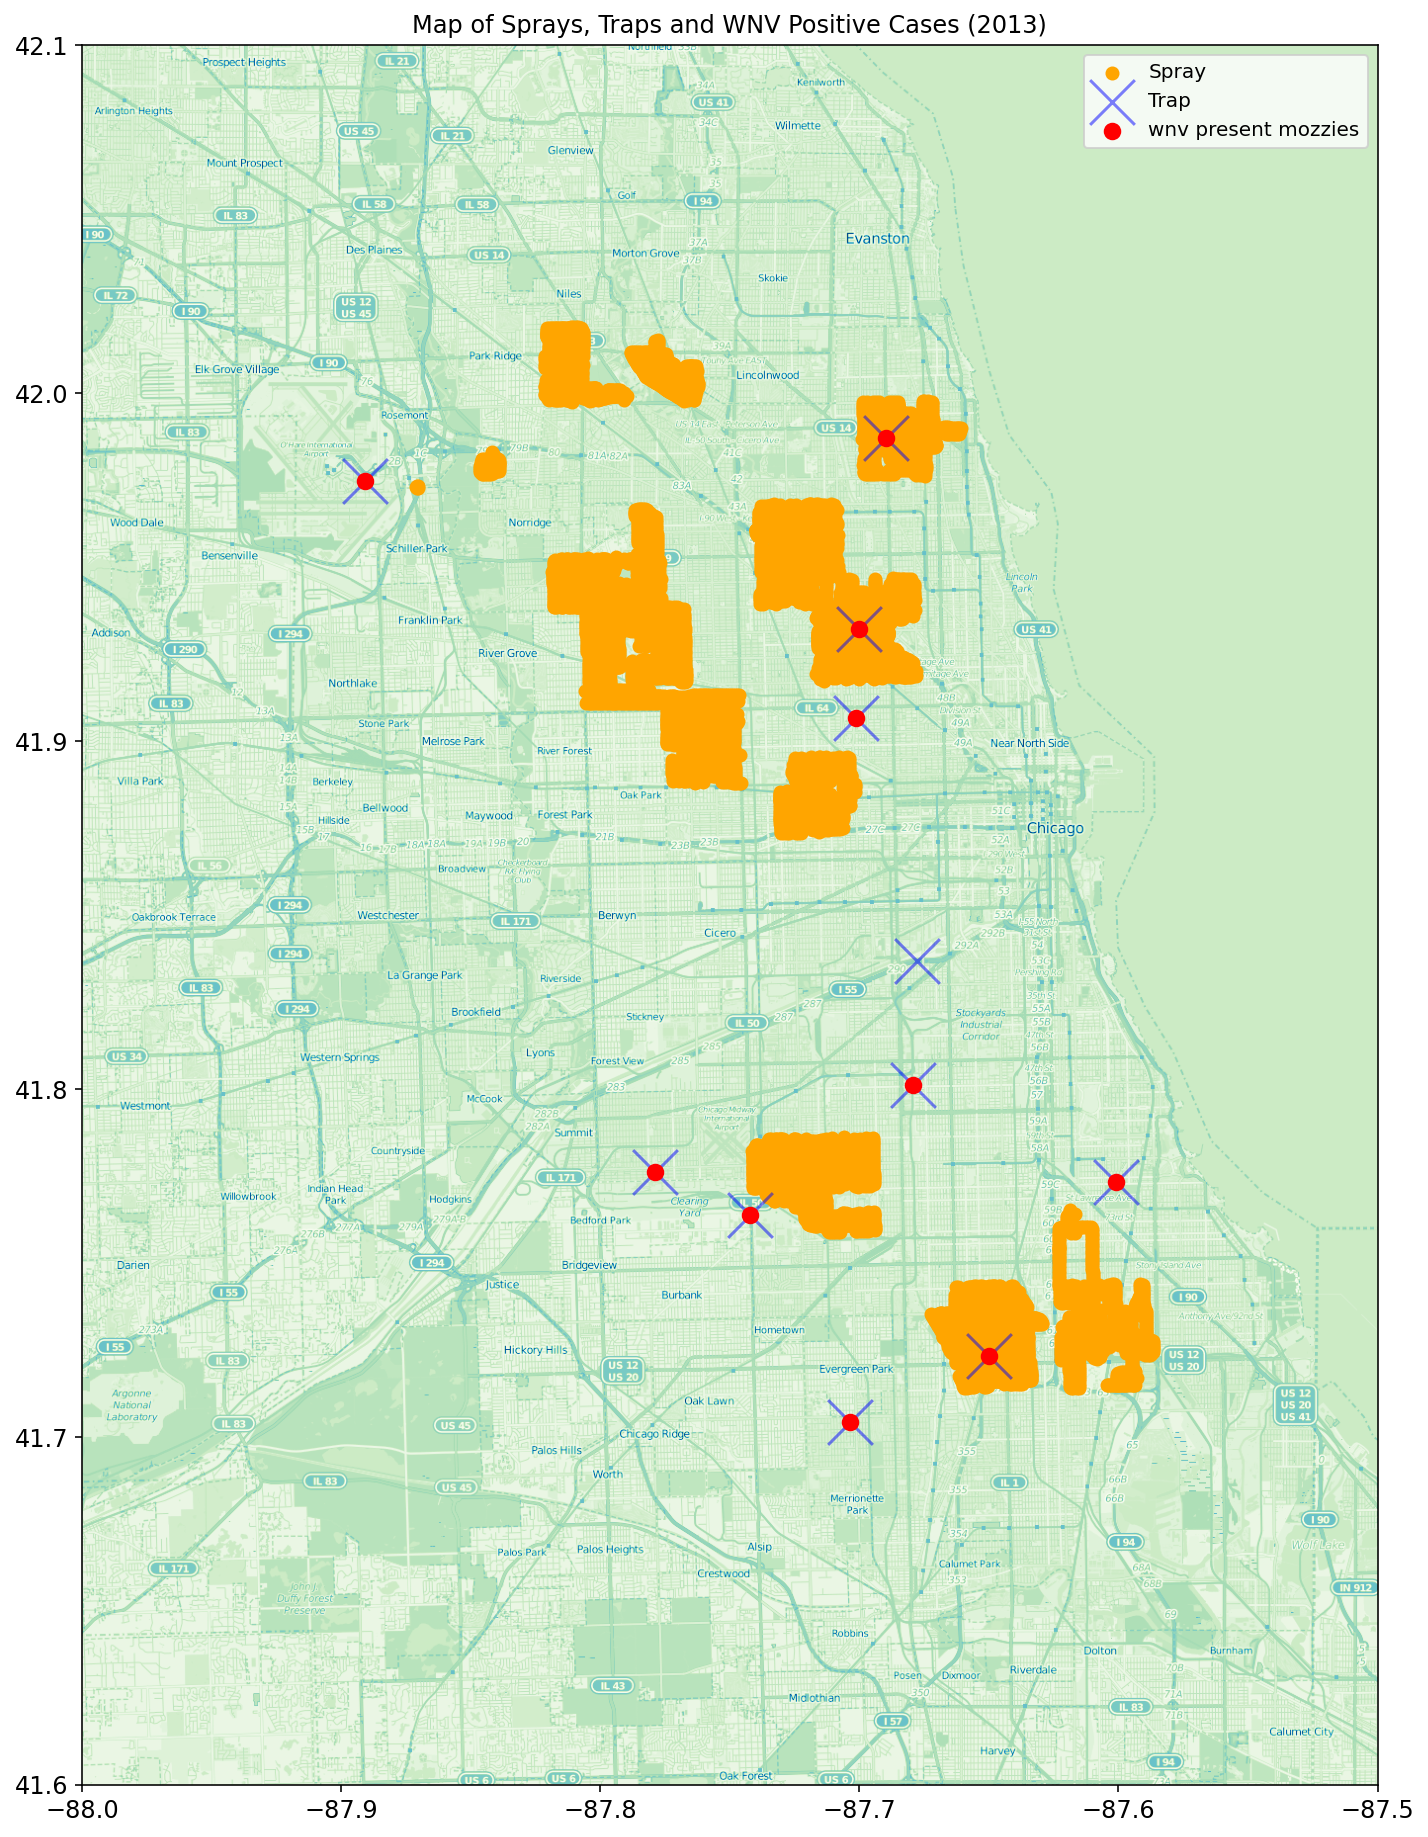

In [654]:
#spray for 2013
mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)
plt.figure(figsize=(20,16))
plt.imshow(mapdata,
           cmap=plt.get_cmap('GnBu_r'),
           extent=lon_lat_box,
           aspect=aspect)

# get 2013 trap data

top_10_traps = lr_lin_coef[lr_lin_coef.index.str.contains('trap')].head(10)

traps_list = []

for i in pd.Series(top_10_traps.index.str.split('_')):
    traps_list.append(i[1])

top_10_traps_df = weather_train_df[weather_train_df['trap'].isin(traps_list)][['date', 'trap','longitude', 'latitude', 'year','wnvpresent']]

trap_values = top_10_traps_df[['longitude', 'latitude']].drop_duplicates().values

#get 2013 spray data
sprays = spray[spray['longitude']>-88]
spray_13 = sprays[sprays["year"]== 2013]
spray_13_values = spray_13[['longitude', 'latitude']].drop_duplicates().values

#get 2013 wnv data
wnvpresent_13 = top_10_traps_df[(top_10_traps_df['wnvpresent'] == 1) & (top_10_traps_df["year"] == 2013)]
wnvpresent_values = wnvpresent_13[['longitude', 'latitude']].drop_duplicates().values

#plot
plt.scatter(spray_13_values[:,0], spray_13_values[:,1], c='orange', alpha=1, label="Spray")
plt.scatter(trap_values[:,0], trap_values[:,1], s = 500, c='blue',marker='x',label='Trap', alpha = 0.5)
plt.scatter(wnvpresent_values[:,0], wnvpresent_values[:,1], s = 60, c='r', marker='o', label='wnv present mozzies')

plt.title('Map of Sprays, Traps and WNV Positive Cases (2013)')
plt.legend();

#alot more spray done in 2013 than 2011. 
#is this effective? have to look at effectiveness of sprays broken down by month

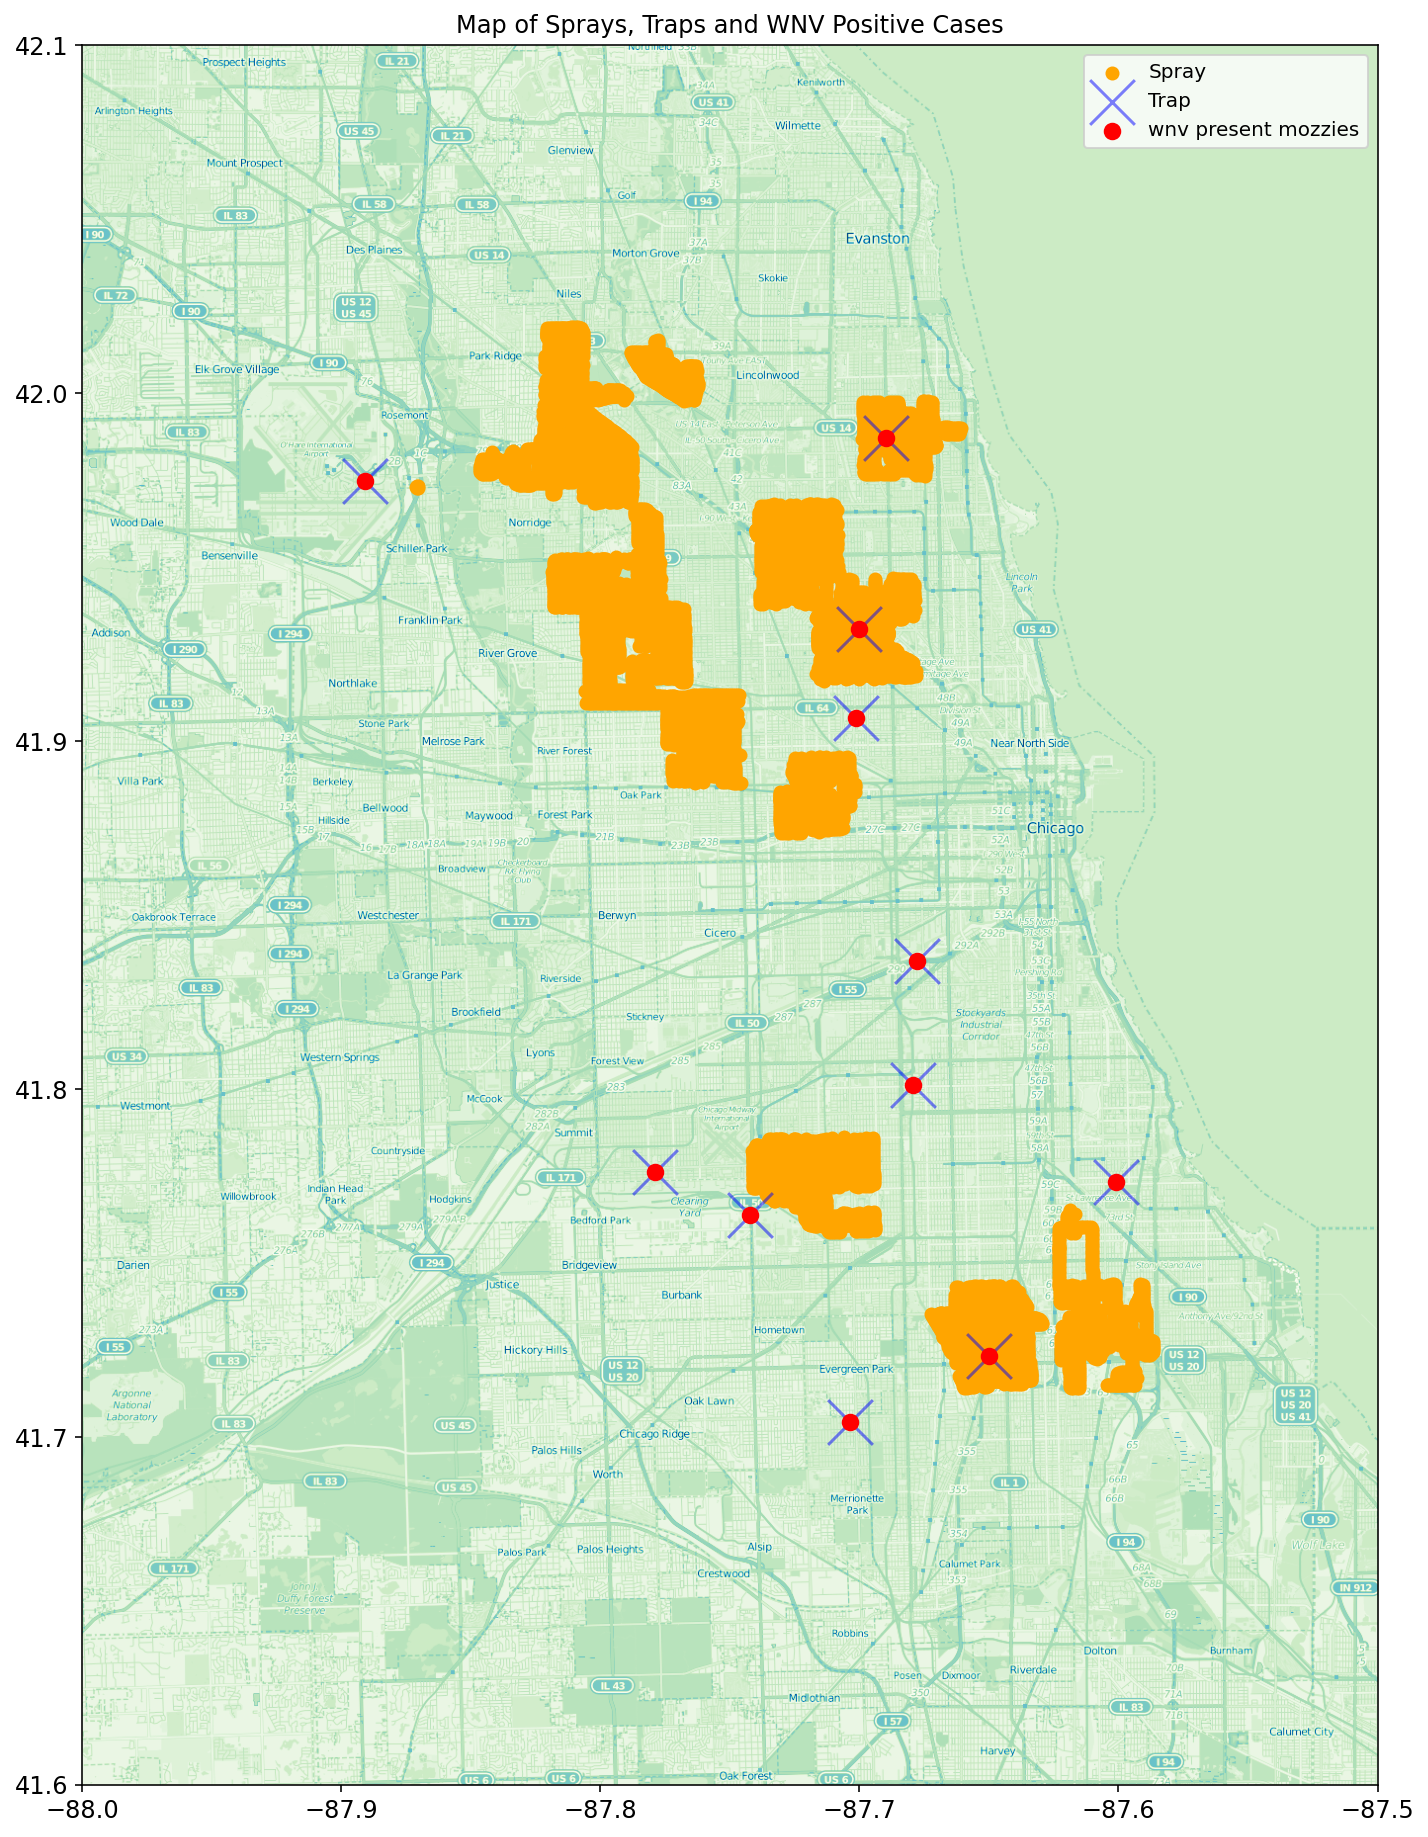

In [655]:
#spray for all years
mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)
plt.figure(figsize=(20,16))
plt.imshow(mapdata,
           cmap=plt.get_cmap('GnBu_r'),
           extent=lon_lat_box,
           aspect=aspect)

# get 2013 trap data

top_10_traps = lr_lin_coef[lr_lin_coef.index.str.contains('trap')].head(10)

traps_list = []

for i in pd.Series(top_10_traps.index.str.split('_')):
    traps_list.append(i[1])

top_10_traps_df = weather_train_df[weather_train_df['trap'].isin(traps_list)][['date', 'trap','longitude', 'latitude', 'year','wnvpresent']]

trap_values = top_10_traps_df[['longitude', 'latitude']].drop_duplicates().values

#get 2013 spray data
sprays = spray[spray['longitude']>-88]
#spray_13 = sprays[sprays["year"]== 2013]
spray_values = sprays[['longitude', 'latitude']].drop_duplicates().values

#get 2013 wnv data
wnvpresent = top_10_traps_df[(top_10_traps_df['wnvpresent'] == 1)]
wnvpresent_values = wnvpresent[['longitude', 'latitude']].drop_duplicates().values

#plot
plt.scatter(spray_values[:,0], spray_values[:,1], c='orange', alpha=1, label="Spray")
plt.scatter(trap_values[:,0], trap_values[:,1], s = 500, c='blue',marker='x',label='Trap', alpha = 0.5)
plt.scatter(wnvpresent_values[:,0], wnvpresent_values[:,1], s = 60, c='r', marker='o', label='wnv present mozzies')

plt.title('Map of Sprays, Traps and WNV Positive Cases')
plt.legend();

#alot more spray done in 2013 than 2011. 
#is this effective? have to look at effectiveness of sprays broken down by month

In [656]:
error_analysis_df = pd.DataFrame(y_test)

In [657]:
error_analysis_df['predictions'] = lr_lin.predict(x_test_sc)

In [299]:
error_analysis_df.rename(columns= {'wnvpresent':'actual'},inplace=True)

In [320]:
false_neg = error_analysis_df[(error_analysis_df['actual']==1) & (error_analysis_df['predictions'] != 1)].index

In [422]:
false_pos = error_analysis_df[(error_analysis_df['actual']==0) & (error_analysis_df['predictions'] != 0)].index

In [327]:
lr_lin_coef.head(10)

#nummosq, months, traps, dewpoint, species


coefficients
nummosquitos               1.785421
month_8                    0.817789
month_9                    0.785394
trap_T900                  0.477832
week*dewpoint              0.461535
species_CULEX PIPIENS      0.396304
trap_T147                  0.312374
trap_T061                  0.308762
trap_T028                  0.308536
trap_T011                  0.292179

In [328]:
lr_lin_coef.tail(10)

#months, traps, species

coefficients
trap_T153                    -0.394375
trap_T043                    -0.406845
month_7                      -0.419713
species_CULEX SALINARIUS     -0.470853
trap_T145                    -0.478890
trap_T069                    -0.524159
trap_T046                    -0.575561
species_CULEX TERRITANS      -0.794702
trap_T200                    -0.801142
month_6                      -0.960229

In [336]:
false_neg_df = weather_train_df[['nummosquitos','month','dewpoint','trap','species']].loc[false_neg]
false_neg_df

nummosquitos  month  dewpoint  trap                 species
8309             3      7        52  T054          CULEX RESTUANS
7955            29      7        53  T228          CULEX RESTUANS
7990            36      7        54  T158          CULEX RESTUANS
4989             2      9        55  T228          CULEX RESTUANS
9486             2      9        58  T232           CULEX PIPIENS
8123            17      7        70  T228  CULEX PIPIENS/RESTUANS
9036             6      8        66  T063  CULEX PIPIENS/RESTUANS
592             50      7        60  T115           CULEX PIPIENS
8642             4      8        55  T089          CULEX RESTUANS
8897            12      8        50  T226           CULEX PIPIENS
9308            17      9        55  T069  CULEX PIPIENS/RESTUANS
2439             4      9        62  T085           CULEX PIPIENS
8544             5      8        54  T221          CULEX RESTUANS
2362             3      9        60  T037  CULEX PIPIENS/RESTUANS
9069             3      8        66  T232  CULEX PIPIENS/RESTUANS
9466             5      9        58  T102  CULEX PIPIENS/RESTUANS
4348            12      7        61  T095  CULEX PIPIENS/RESTUANS
2057            47      8        70  T200           CULEX PIPIENS
1643            25      8        69  T145           CULEX PIPIENS
8143            16      7        69  T031  CULEX PIPIENS/RESTUANS
6194            16      7        67  T225          CULEX RESTUANS

In [423]:
false_pos_df = weather_train_df[['nummosquitos','month','dewpoint','trap','species']].loc[false_pos]
false_pos_df

nummosquitos  month  dewpoint  trap                 species
4556            12      8        59  T900  CULEX PIPIENS/RESTUANS
2678             1      9        58  T013  CULEX PIPIENS/RESTUANS
4110            47      7        51  T900  CULEX PIPIENS/RESTUANS
4540             6      8        59  T218  CULEX PIPIENS/RESTUANS
6897             8      9        69  T094  CULEX PIPIENS/RESTUANS
...            ...    ...       ...   ...                     ...
1168             3      8        66  T135  CULEX PIPIENS/RESTUANS
1053             2      8        63  T081  CULEX PIPIENS/RESTUANS
1467             9      8        72  T107           CULEX PIPIENS
4377             8      7        61  T900  CULEX PIPIENS/RESTUANS
6557             2      8        57  T066  CULEX PIPIENS/RESTUANS

[689 rows x 5 columns]

(array([0, 1, 2]),
 [Text(0, 0, 'CULEX PIPIENS/RESTUANS'),
  Text(1, 0, 'CULEX RESTUANS'),
  Text(2, 0, 'CULEX PIPIENS')])

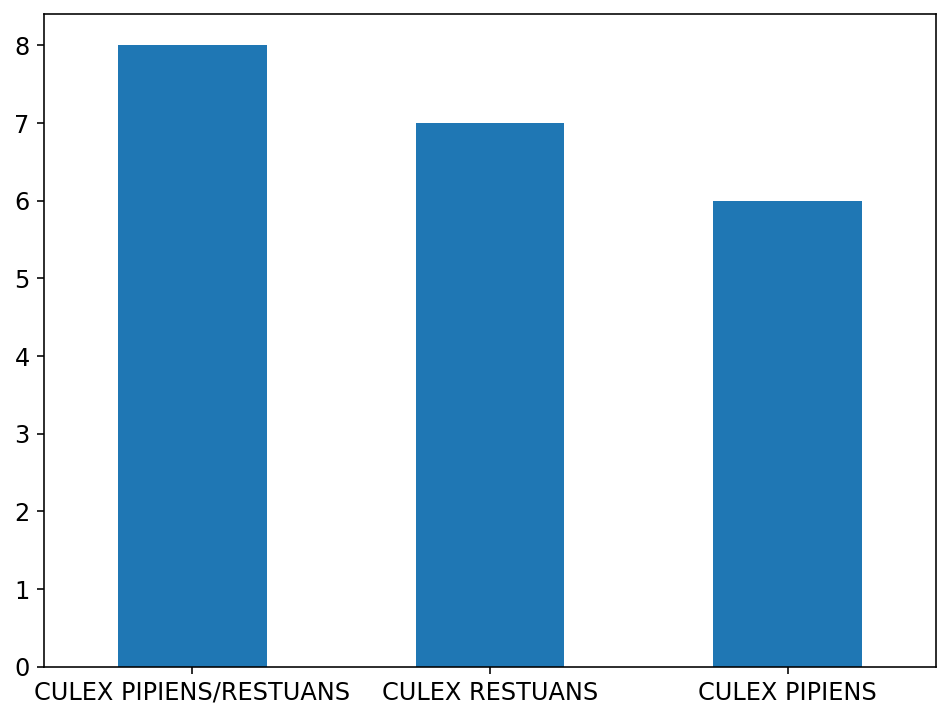

In [357]:
plt.figure(figsize=(8,6))
false_neg_df['species'].value_counts().plot.bar()
plt.xticks(rotation = 360)

# only these 3 species have wnv, so not surprising that misclassifications all belong to these species

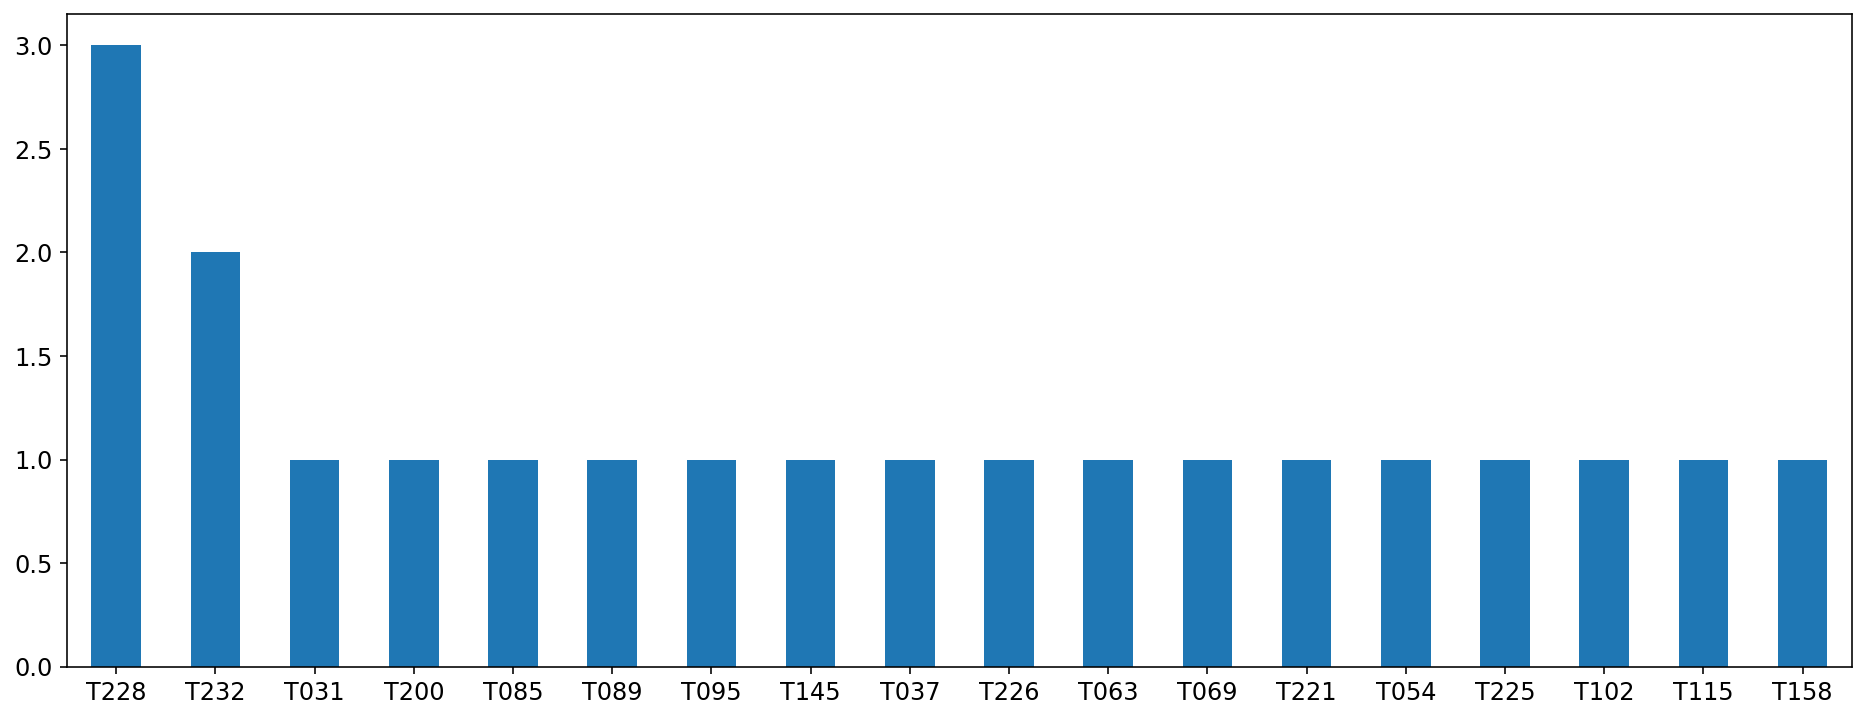

In [362]:
plt.figure(figsize=(16,6))
false_neg_df['trap'].value_counts().plot.bar()
plt.xticks(rotation = 360)
plt.show()

In [373]:
#display general percentage
weather_train_df['wnvpresent'].value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [374]:
weather_train_df[(weather_train_df['trap']=='T228')|(weather_train_df['trap']=='T232')]['wnvpresent'].value_counts(normalize=True)

# It indeed has higher percentage of wnv present. 
# Hence, our model should detect it. It should be other factors affecting it.

0    0.928571
1    0.071429
Name: wnvpresent, dtype: float64

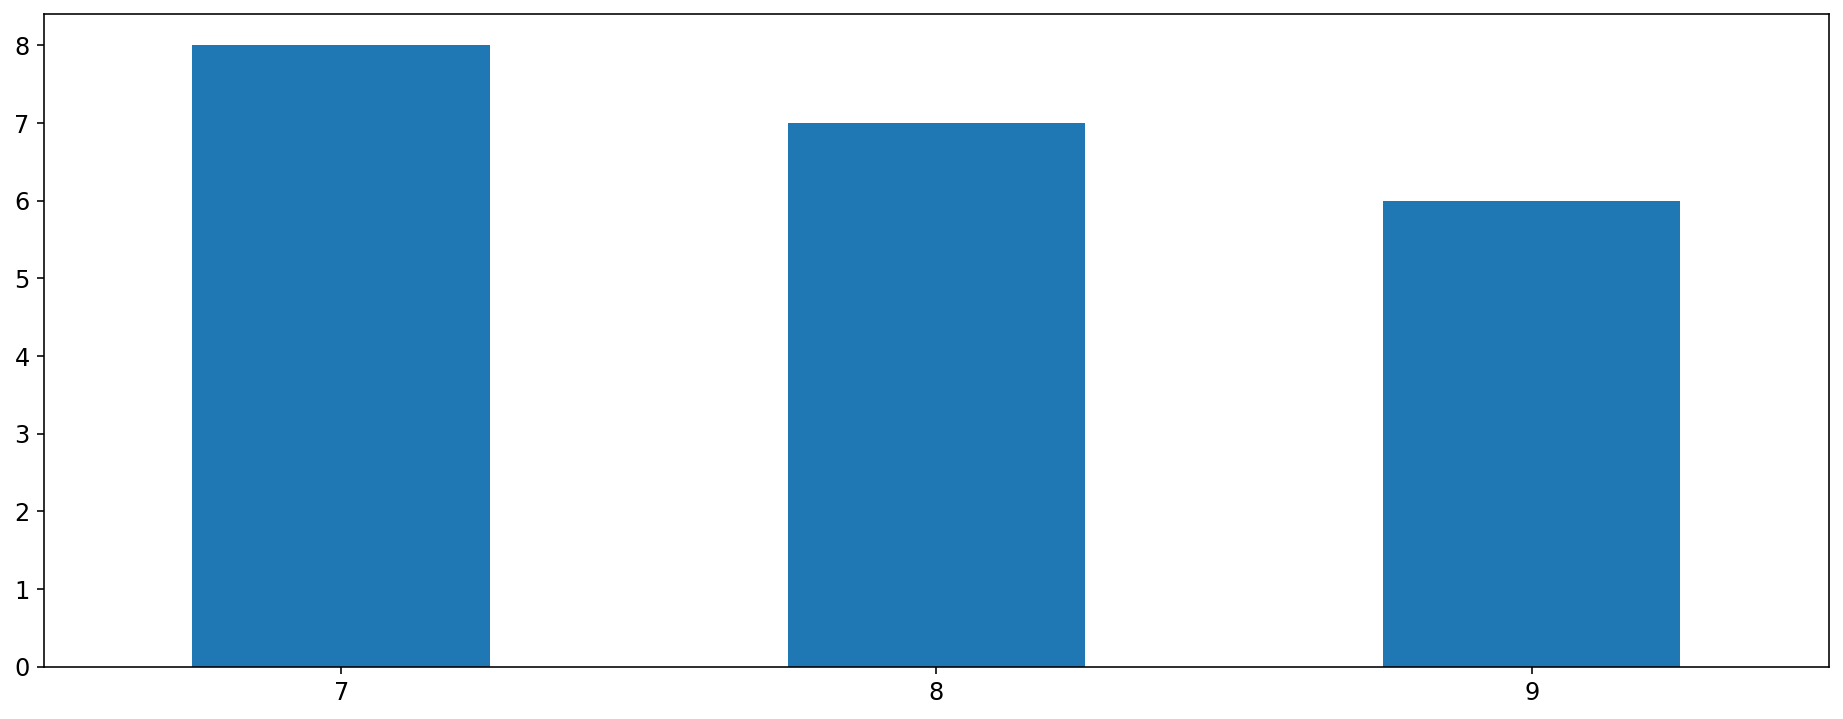

In [376]:
plt.figure(figsize=(16,6))
false_neg_df['month'].value_counts().plot.bar()
plt.xticks(rotation = 360)
plt.show()

# It is surprising that the model did not classify the months in august as wnvpresent.
# However, it is understandable that the model classified the months of july and september wrongly as the wnv virus in those months are less

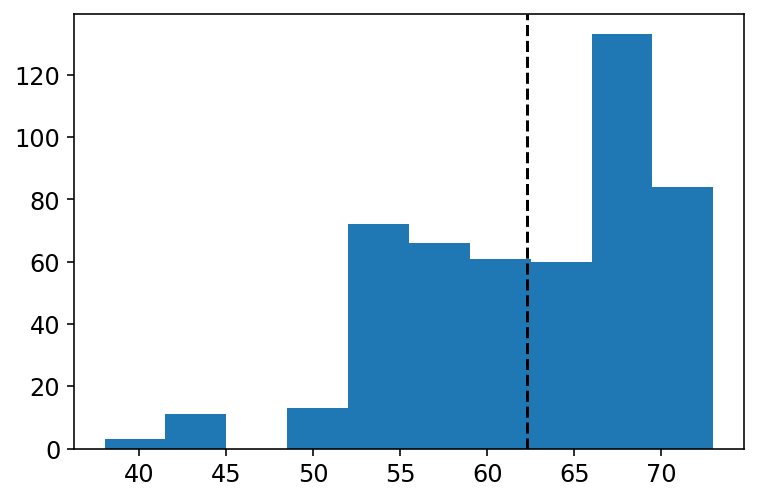

In [414]:
plt.hist(weather_train_df[weather_train_df['wnvpresent']==1]['dewpoint'])
plt.axvline(weather_train_df[weather_train_df['wnvpresent']==1]['dewpoint'].mean(), c = 'black', ls = '--')

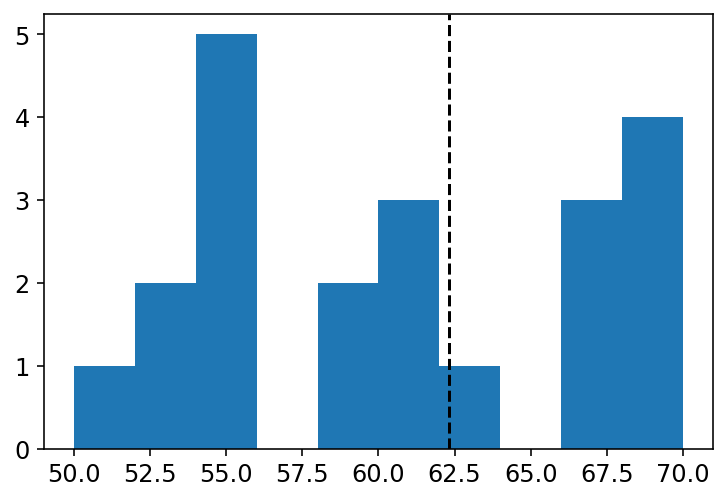

In [415]:
plt.hist(false_neg_df['dewpoint'])
plt.axvline(weather_train_df[weather_train_df['wnvpresent']==1]['dewpoint'].mean(), c = 'black', ls = '--')

# understandable that we misclassified many of those below 55 as those are deemed to have less chance of wnv

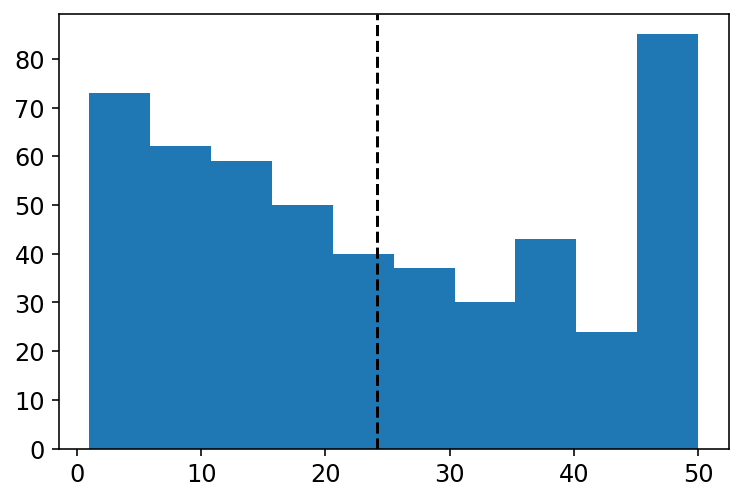

In [416]:
plt.hist(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'])
plt.axvline(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'].mean(), c = 'black', ls = '--')

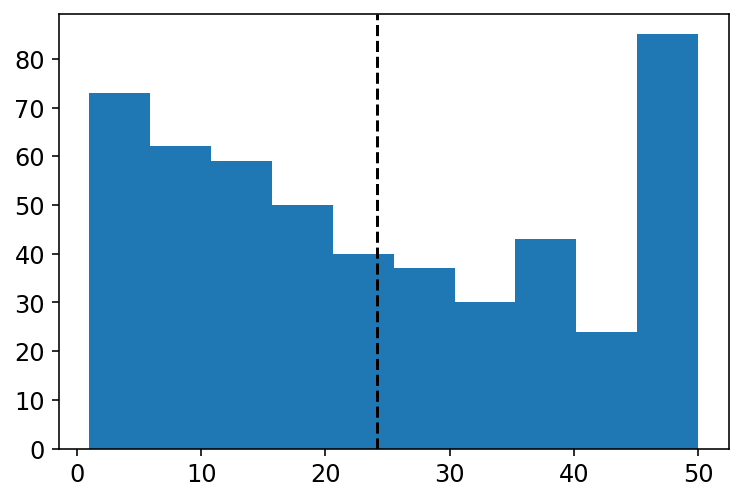

In [436]:
plt.hist(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'])
plt.axvline(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'].mean(), c = 'black', ls = '--')

#Linear regression could have misclassified it.

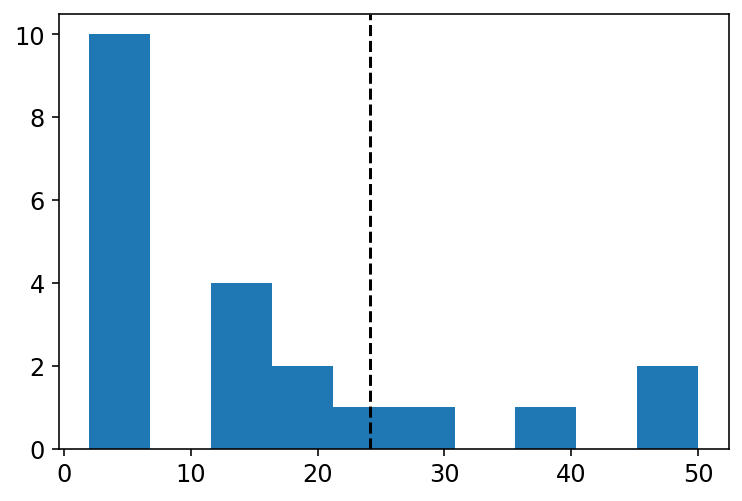

In [435]:
plt.hist(false_neg_df['nummosquitos'])
plt.axvline(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'].mean(), c = 'black', ls = '--')

#Linear regression could have misclassified it.

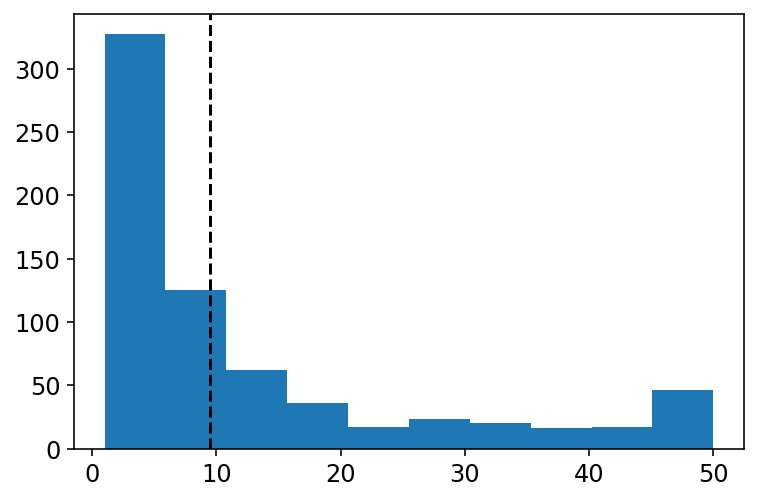

In [432]:
plt.hist(false_pos_df['nummosquitos'])
plt.axvline(weather_train_df[weather_train_df['wnvpresent']==0]['nummosquitos'].mean(), c = 'black', ls = '--')

#Linear regression could have misclassified it.